# Leave Classifier
The following project is based upon the data found at: https://www.muratkoklu.com/datasets/ and was developed using the Kaggle data source at https://www.kaggle.com/datasets/muratkokludataset/grapevine-leaves-image-dataset/data.

The dataset represents images of a number of leaves of different grape vines and the classificatin of their type

The goal of the model is to develop a modle that can distuingish effectively what type of grape vine a leaf is from.


In [1]:
# Import all required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import tensorflow as tf  
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19  
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Conv2D, MaxPool2D

2024-06-18 12:17:28.091139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 12:17:28.091245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 12:17:28.229517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis (EDA)



### Review Structure of the Data Source Directory

In [2]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

As can be seen the impages are stored as .png files in subdirectory whose name represents the class of wine leaf

In [3]:
#get the name of each of the sub-directorys - need to ensure the .txt file in main directory is excluded
root_dir = '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset'

classes_dirs = []
for folder in os.listdir(root_dir):
    n = os.path.join( root_dir, folder)
    if (os.path.isdir(n)):
        print (n)
        classes_dirs.append(n)


        
        

/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Ala_Idris
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Nazli
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Dimnit
/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Ak


In [4]:
#Get a few sample leaves to display for initial visual inspection
samples = []
names = []
count_per_class = []
for class_path in classes_dirs:
    paths = os.listdir(class_path)
    paths = random.sample(paths , 4)
    images_in_class = os.listdir(os.path.join(root_dir, class_path))
    count_per_class.append(len(images_in_class))
    for file_path in paths:
        samples.append(os.path.join( class_path, file_path))
        names.append(file_path)

/tmp/ipykernel_62/1558477996.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


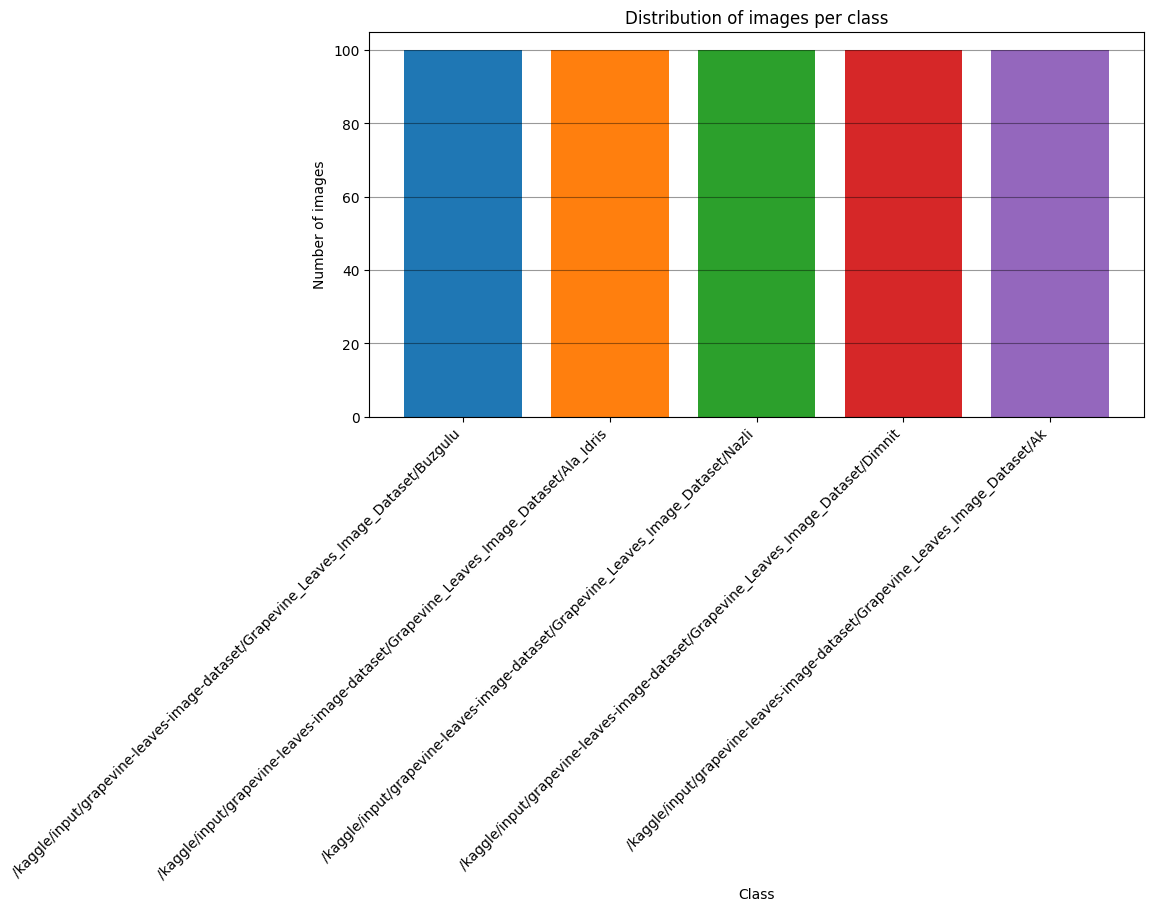

In [5]:
cmap = cm.tab10
plt.figure(figsize = (10, 5))
bars = plt.bar(classes_dirs, count_per_class, color = cmap(range(len(classes_dirs))))
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Distribution of images per class')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.grid(axis = 'y', which = 'both', alpha = 0.4, color = 'black')
plt.show()

(511, 511, 4)


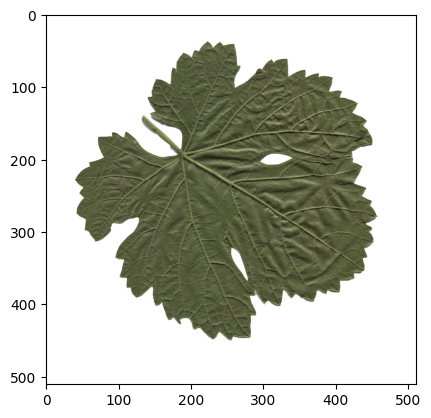

In [6]:
# Inspect one image to determine size, shape and overall look
img = mpimg.imread(samples[1])
print (img.shape)
plt.imshow(img)

As can be seen from the above the images are 512X512 with 4 layers.

As a next step plot the samples from each of the vine types

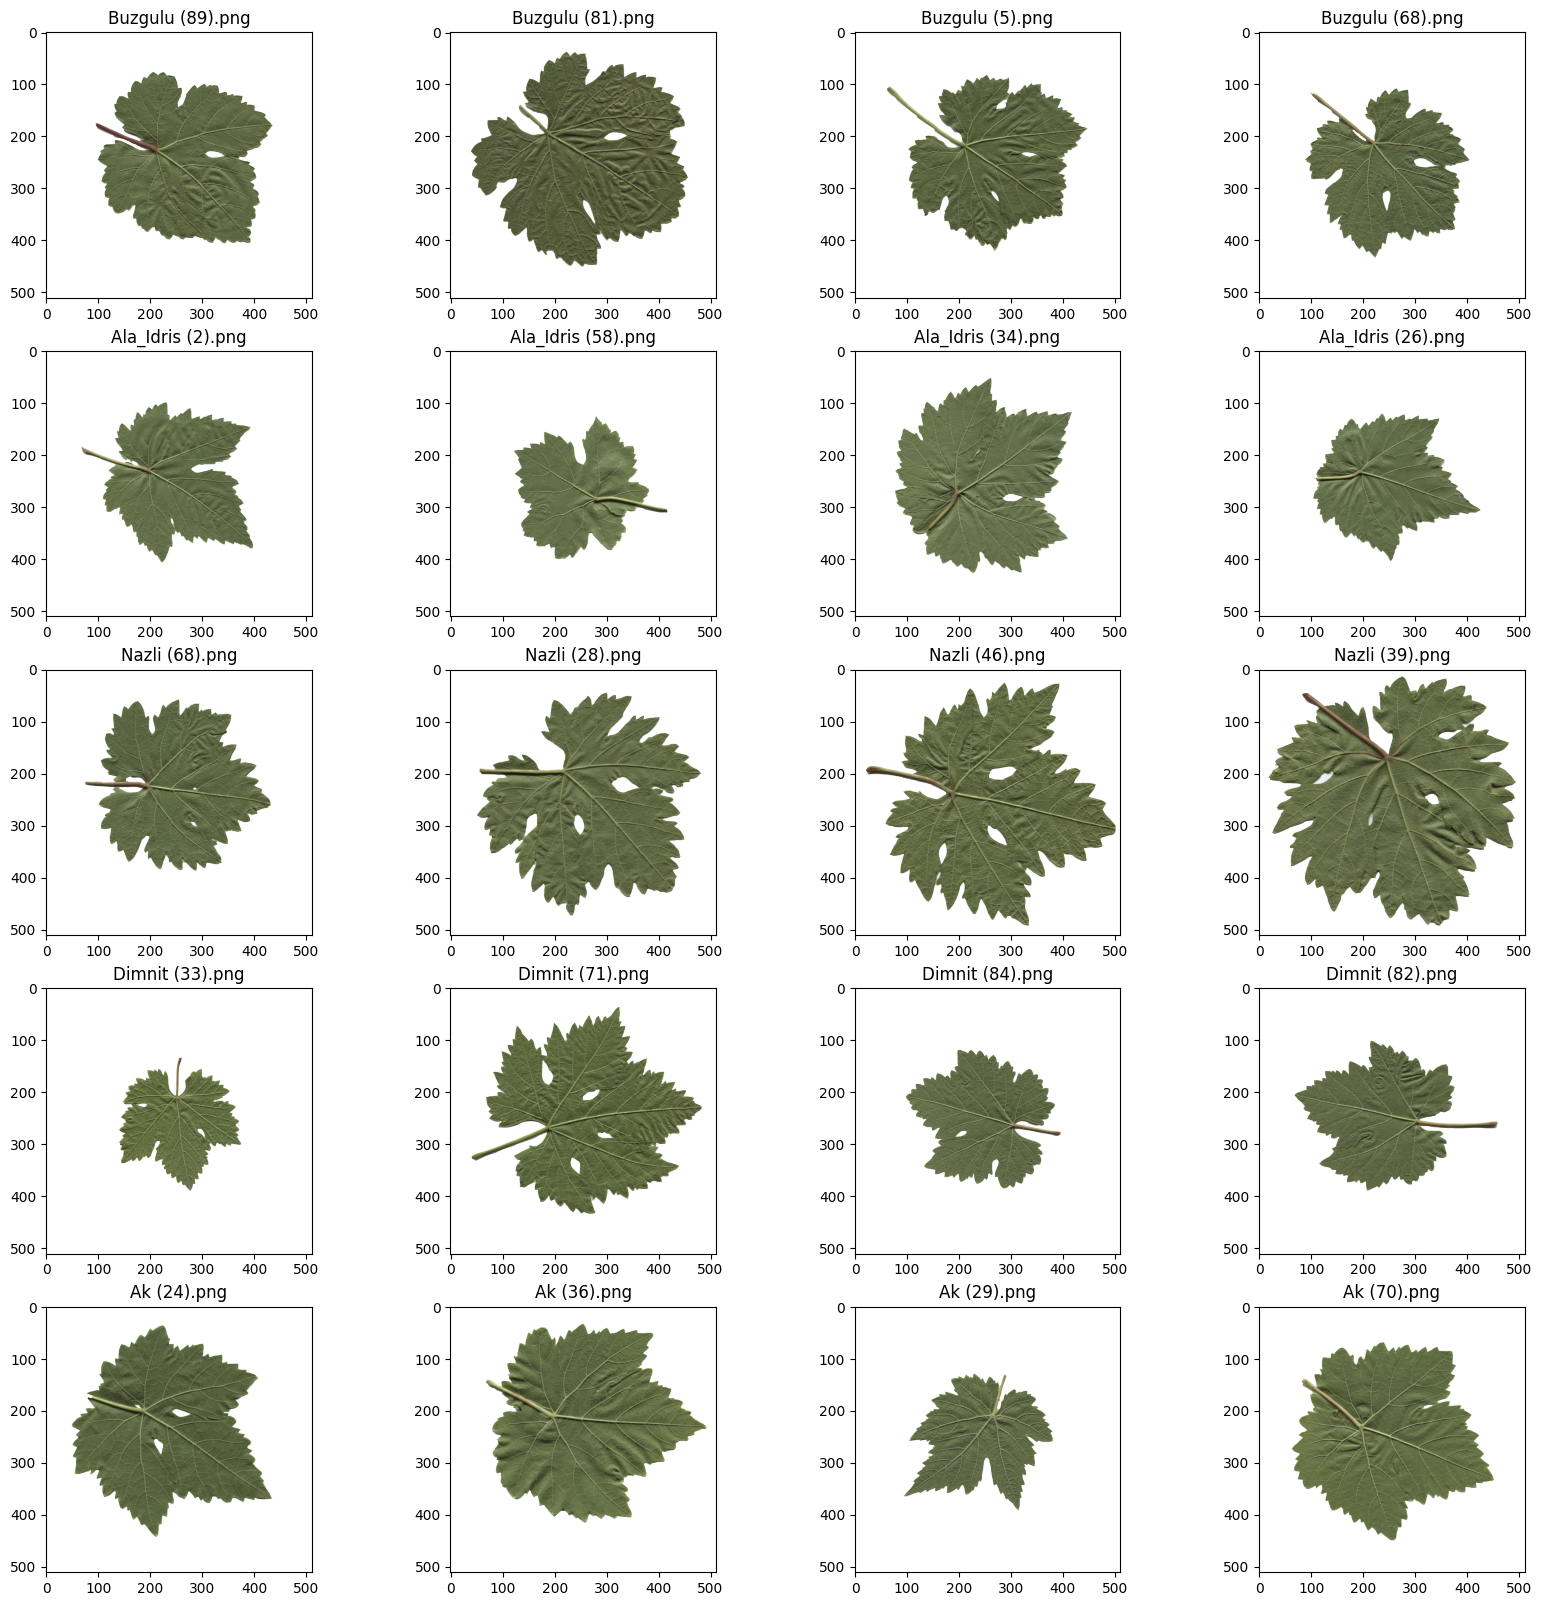

In [7]:
fig = plt.gcf()
fig.set_size_inches(20 , 20)

for idx , ele in enumerate(samples):
    subplot = plt.subplot( 5 , 4,idx+1)
    img = mpimg.imread(ele)
    plt.imshow(img)
    plt.title(names[idx])

plt.show()

In looking at the above samples, there appear to be some common traits to each vine class that a CNN model could pick up.
1. The shape of the leaf appears distinct for each type with differnt leaf branches
2. Also there appear to be common numbetr of leafs holes for each category.

## Develop Deep Learning Model
For the purposes of this project a convolutional neural network (CNN) model will be developed.

A  CNN model is generally considered an appropriate form of deep learning model to perform image recognition

## Set up the training data, seeting aside 20% of the data for validation and batch sizes of 32

In [8]:


seed = 50 
train_data = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,  
    subset='training',  
    seed=seed  
)


validation_data = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,  
    subset='validation',  
    seed=seed  
)

train_data = train_data.map(lambda x, y: (x / 255.0, y))
validation_data = validation_data.map(lambda x, y: (x / 255.0, y))

Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


## Build a DenseNet121 Model

The code below initializes a DenseNet121 model.  DenseNet121 a form of CNN know for its dense connectivity pattern,and allows for feature reuse and propagation throughout the network.
The key parameters include:
1. weight : for which imagement net was selected,  imagenet is a pretrained Keras weights model
2. include_top : whether to include the fully-connected layer at the top of the network
3. We will set the trainable fla tot false, which freezes the weights of pre-trained DenseNet121 models.  This helps in utilizing the features from teh ImageNet dataset without altering them, thereby also reducing the computational cost and training time.

In [9]:
conv_base = DenseNet121(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg',

)
conv_base.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Build the actual CNN model
Buidling 3 different models with varying levels of complexity to compare results
1. Model1 - to use the DenseNet121 model defined above
2. Model2 - to use a more complex version of a DenseNet121 model (including additional layers and dropout)

### Model 1

In [24]:
model1 = Sequential()
model1.add(conv_base)
model1.add(BatchNormalization())
model1.add(Dense(5, activation='softmax'))
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:

model2 = Sequential()
model2.add(conv_base)
model2.add(BatchNormalization())
model2.add(Dropout(0.35))
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.35))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(5, activation='softmax'))

model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

## Train the Model

In [25]:

start_time = time.time()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train_data, epochs=50, validation_data=validation_data)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.2827 - loss: 1.6971 - val_accuracy: 0.3900 - val_loss: 1.3995
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6737 - loss: 0.9045 - val_accuracy: 0.4000 - val_loss: 1.2859
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8162 - loss: 0.5847 - val_accuracy: 0.4600 - val_loss: 1.1959
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8915 - loss: 0.4468 - val_accuracy: 0.4700 - val_loss: 1.1170
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9139 - loss: 0.3703 - val_accuracy: 0.4900 - val_loss: 1.0409
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9470 - loss: 0.2904 - val_accuracy: 0.5700 - val_loss: 0.9869
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9503 - loss: 0.2573 - val_accuracy: 0.6000 - val_loss: 0.9002
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9608 - loss: 0.2417 - val_accuracy: 0.6400 - va

In [15]:
start_time = time.time()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_data, epochs=50, validation_data=validation_data)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3372 - loss: 1.6573 - val_accuracy: 0.4800 - val_loss: 1.2894
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8046 - loss: 0.5685 - val_accuracy: 0.5200 - val_loss: 1.1310
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8504 - loss: 0.4154 - val_accuracy: 0.6200 - val_loss: 0.9820
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8836 - loss: 0.2734 - val_accuracy: 0.7000 - val_loss: 0.8691
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9314 - loss: 0.2299 - val_accuracy: 0.7000 - val_loss: 0.7972
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9779 - loss: 0.1229 - val_accuracy: 0.7100 - val_loss: 0.7193
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9747 - loss: 0.1221 - val_accuracy: 0.7200 - val_loss: 0.6768
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.9662 - loss: 0.1023 - val_accuracy: 0.770

## Evaluate the Model

In [26]:
evaluation = model1.evaluate(validation_data)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])



evaluation = model2.evaluate(validation_data)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8761 - loss: 0.2870
Validation Loss: 0.27292048931121826
Validation Accuracy: 0.8700000047683716
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9128 - loss: 0.2892
Validation Loss: 0.2511087656021118
Validation Accuracy: 0.9200000166893005


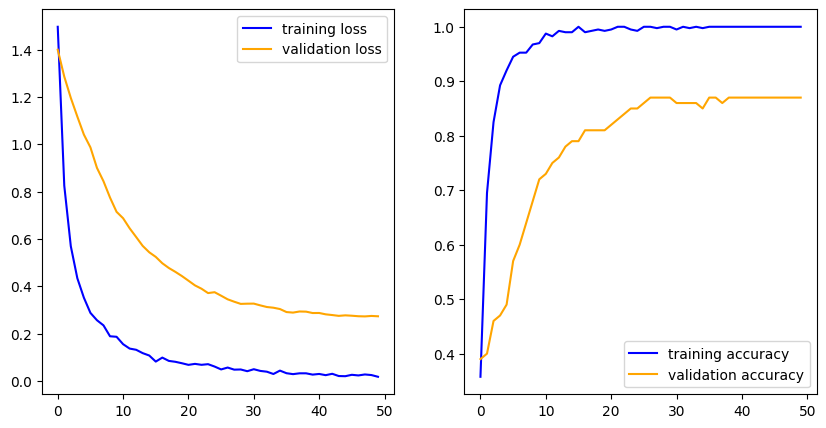

In [27]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']


fig = plt.gcf()
fig.set_size_inches(10, 5)



subplot = plt.subplot( 1 , 2,1)
plt.plot(loss , 'b' , label = 'training loss')
plt.plot(val_loss , 'orange' , label = 'validation loss')
plt.legend()


subplot = plt.subplot( 1 , 2,2)
plt.plot(acc , 'b' , label = 'training accuracy')
plt.plot(val_acc , 'orange' , label = 'validation accuracy')
plt.legend()



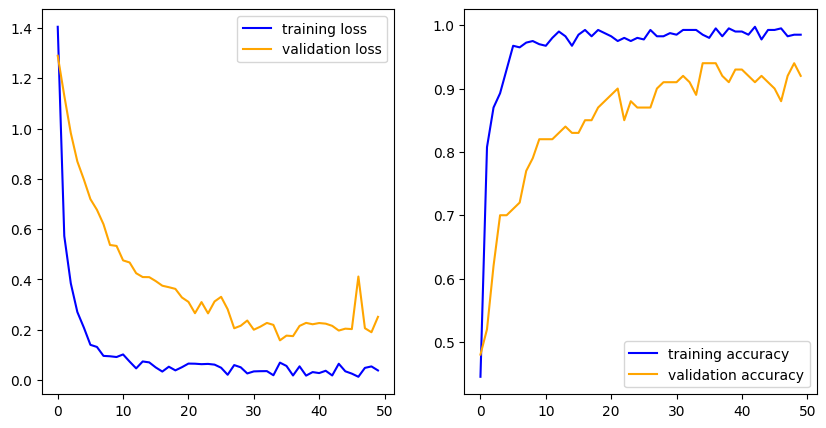

In [28]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']


fig = plt.gcf()
fig.set_size_inches(10, 5)



subplot = plt.subplot( 1 , 2,1)
plt.plot(loss , 'b' , label = 'training loss')
plt.plot(val_loss , 'orange' , label = 'validation loss')
plt.legend()


subplot = plt.subplot( 1 , 2,2)
plt.plot(acc , 'b' , label = 'training accuracy')
plt.plot(val_acc , 'orange' , label = 'validation accuracy')
plt.legend()

## Conclusion and Summary

As can be seen from the above results, both the models gave reasonable results.  The base model was close to 90% whereas the more complex model was over 90%.  

Looking at the above graphs, it appears that both models converged within the 30 iterations set out

However looking at the speed of run time, the more complex model was only 10 seconds longer in run time that the simple model and provided much better results.  Therefore the additional filters and dropout appear to be warranted